In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
# from numba import jit, njit, vectorize, guvectorize, float64

plt.style.use(['science', 'grid', 'notebook'])

In [2]:
# Definición de constantes del sistema
Vna = 50    # mV
Vk = -77
Vl = -54.4
Vsyn = 0
gna = 120   # mS/cm^2
gk = 36
gl = 0.3

tau_s = 3  # ms (constante de tiempo de la sinapsis)

C = 1   # microF/cm^2

# Definición de funciones de comportamiento de la membrana

def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-0.1 * (V + 40)))

def beta_m(V):
    return 4 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1 / (1 + np.exp(-0.1 * (V + 35)))

def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)


# definicion de X_inf y tau_x
# @jit(forceobj=True)

def x_inf(V):
    
    return np.array([alpha_m(V) / (alpha_m(V) + beta_m(V)), alpha_h(V) / (alpha_h(V) + beta_h(V)), alpha_n(V) / (alpha_n(V) + beta_n(V)), 0.5*(1 + np.tanh(V[::-1]/5))])  # Se agrega la variable de estado de la sinapsis


def tau_x(V):
    return np.array([1 / (alpha_m(V) + beta_m(V)), 1 / (alpha_h(V) + beta_h(V)), 1 / (alpha_n(V) + beta_n(V)), tau_s*np.ones_like(V)])  # Se agrega la variable de estado de la sinapsis

In [3]:
def euler_eq_resolver(seed, time_limits, delta_t, dydx, args):
    time_axis = np.arange(*time_limits, delta_t)    # defino eje temporal
    results = np.empty((time_axis.size, *seed.shape))            # defino matriz de potencial de membrana y variables de comportamiento
    # print(results.shape)
    results[0] = np.copy(seed)    # copio condiciones iniciales

    for i in range(1, time_axis.size):
        results[i] = results[i - 1] + delta_t * dydx(results[i - 1], args)
    return results

In [6]:
N_neurons = 2

delta_t = 0.01
time_limits = (0, 2000)

V_seed = np.array([-60, -70])
seed = np.array([V_seed, *x_inf(0.9*V_seed)]) # la condicion inicial cerca del potencial de reposo
print(seed)
print(seed.shape)

def dVdt(V, m, h, n, s, args):
    gna, gk, gl, gsyn, Vna, Vk, Vl, Vsyn, I = args
    return (I - gna * m**3 * h * (V - Vna) - gk * n**4 * (V - Vk) - gl * (V - Vl) - gsyn * s * (V - Vsyn) ) / C

def dxdt(x, V):
    return (x_inf(V) - x) / tau_x(V)

def derivate_system(x, args):
    return np.array([dVdt(x[0], *x[1:], args), *dxdt(x[1:], x[0])])

[[-6.00000000e+01 -7.00000000e+01]
 [ 1.74285249e-01  6.68181110e-02]
 [ 2.36877891e-01  5.24922526e-01]
 [ 4.90985931e-01  3.48720210e-01]
 [ 1.13705156e-11  4.16139734e-10]]
(5, 2)


In [17]:
gsyn_limits = (0, 2)
N_gsyn_points = 10
gsyn_values = np.linspace(*gsyn_limits, N_gsyn_points)


results = np.empty((N_gsyn_points, int((time_limits[1] - time_limits[0]) / delta_t), *seed.shape))

for i, gsyn in enumerate(tqdm.tqdm(range(N_gsyn_points))):
    args = (gna, gk, gl, gsyn, Vna, Vk, Vl, Vsyn, 10)
    results[i] = euler_eq_resolver(seed, time_limits, delta_t, derivate_system, args)

print(results.shape)

100%|██████████| 10/10 [02:18<00:00, 13.86s/it]


(10, 200000, 5, 2)
-------------------------------------
gsyn = 0.0
Delta spikes: 14.629999999999882, ms
Desfasaje: 7.009999999999991, ms -> 3.01 rad
-------------------------------------


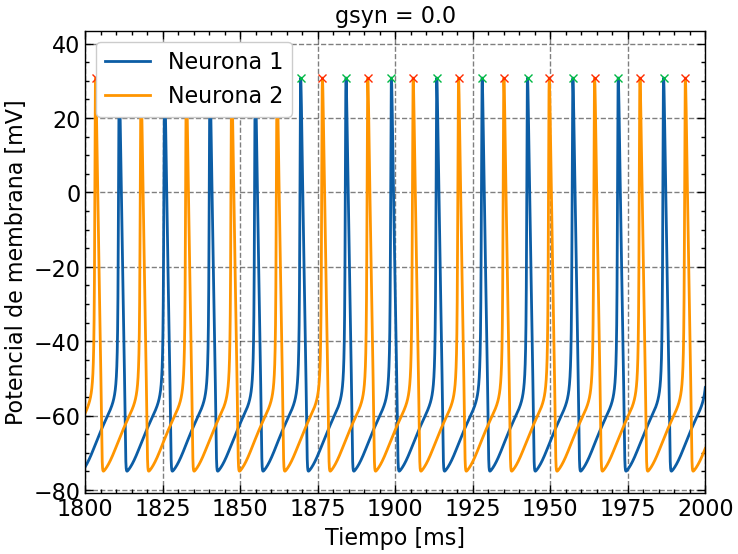

-------------------------------------
gsyn = 0.2222222222222222
Delta spikes: 15.769999999999982, ms
Desfasaje: 0.0, ms -> 0.00 rad
-------------------------------------


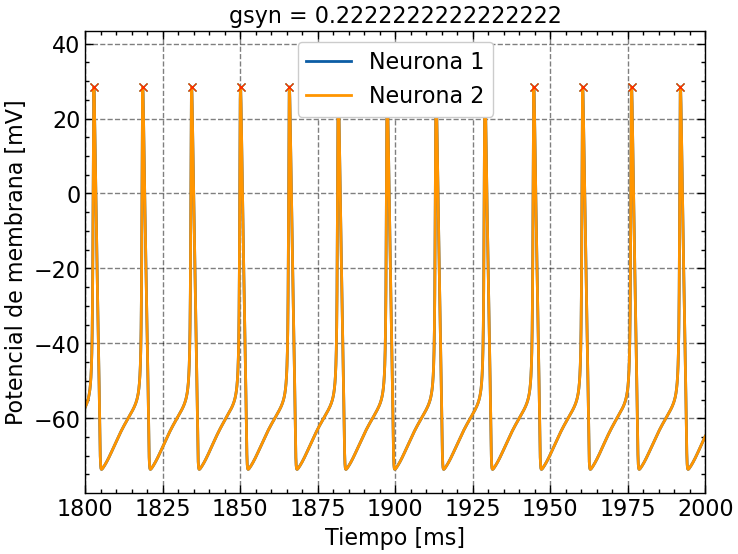

-------------------------------------
gsyn = 0.4444444444444444
Delta spikes: 16.079999999999927, ms
Desfasaje: 1.5399999999999636, ms -> 0.60 rad
-------------------------------------


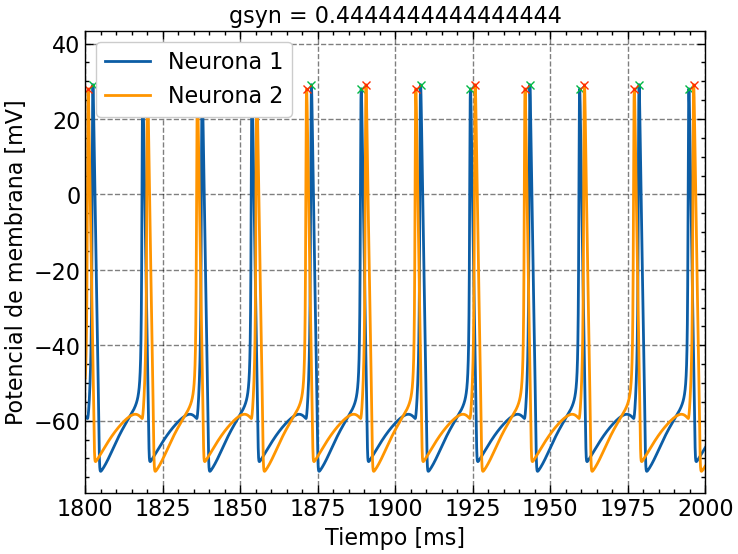

-------------------------------------
gsyn = 0.6666666666666666
Delta spikes: 20.279999999999973, ms
Desfasaje: -1.3199999999999363, ms -> -0.41 rad
-------------------------------------


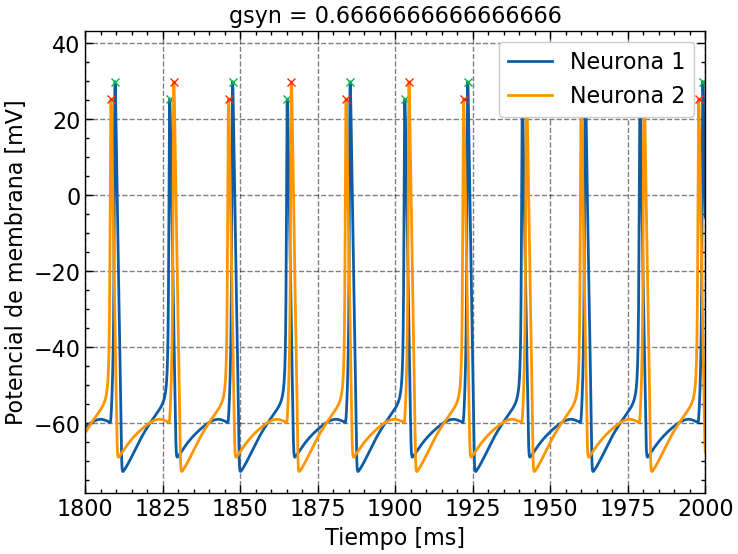

-------------------------------------
gsyn = 0.8888888888888888
Delta spikes: 40.210000000000036, ms
Desfasaje: 1.1900000000000546, ms -> 0.19 rad
-------------------------------------


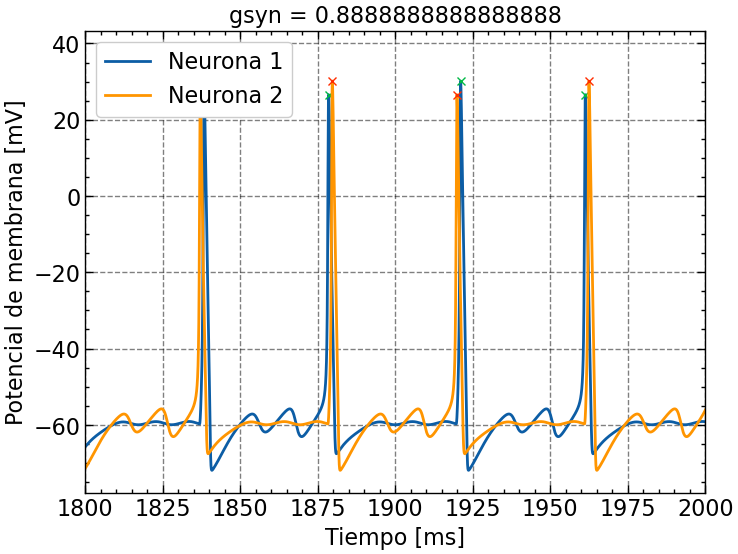

-------------------------------------
gsyn = 1.1111111111111112
Delta spikes: 63.319999999999936, ms
Desfasaje: 1.1000000000001364, ms -> 0.11 rad
-------------------------------------


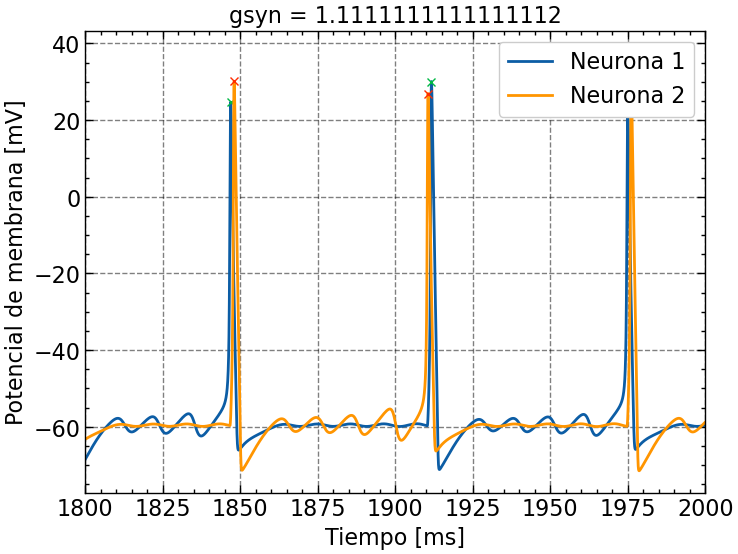

-------------------------------------
gsyn = 1.3333333333333333
Delta spikes: 84.36000000000013, ms
Desfasaje: 1.0399999999999636, ms -> 0.08 rad
-------------------------------------


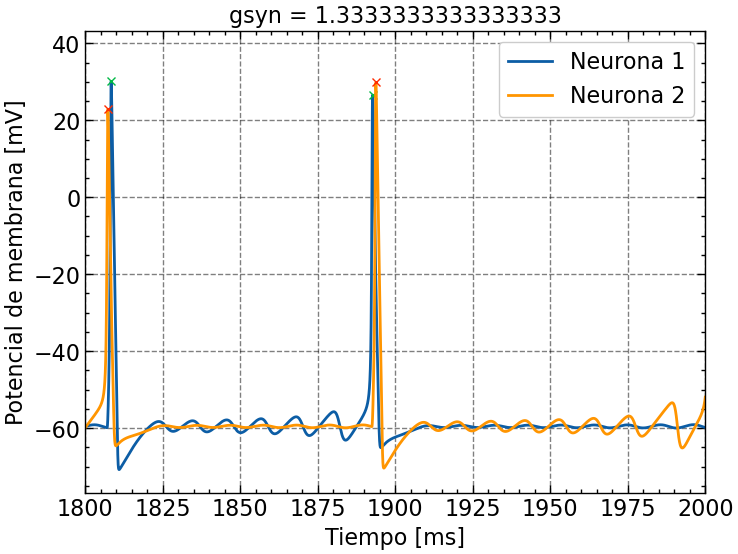

-------------------------------------
gsyn = 1.5555555555555554
Delta spikes: 87.82000000000016, ms
Desfasaje: -0.9900000000000091, ms -> -0.07 rad
-------------------------------------


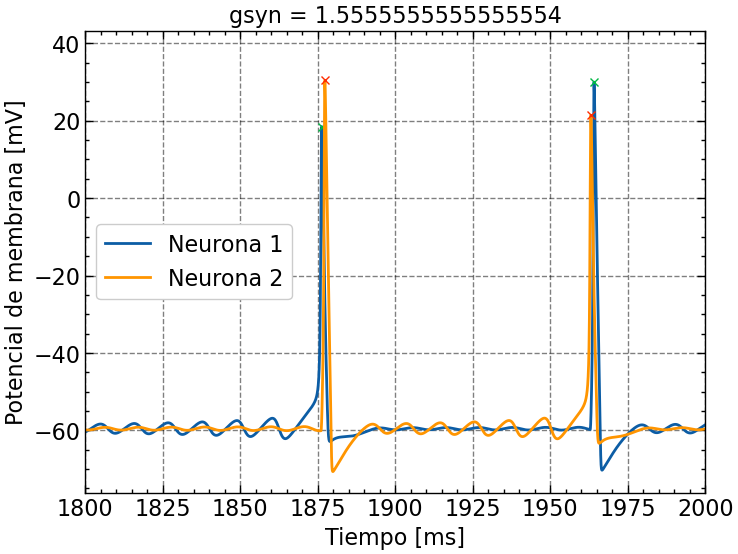

-------------------------------------
gsyn = 1.7777777777777777
Delta spikes: 171.15999999999985, ms
Desfasaje: 0.9500000000000455, ms -> 0.03 rad
-------------------------------------


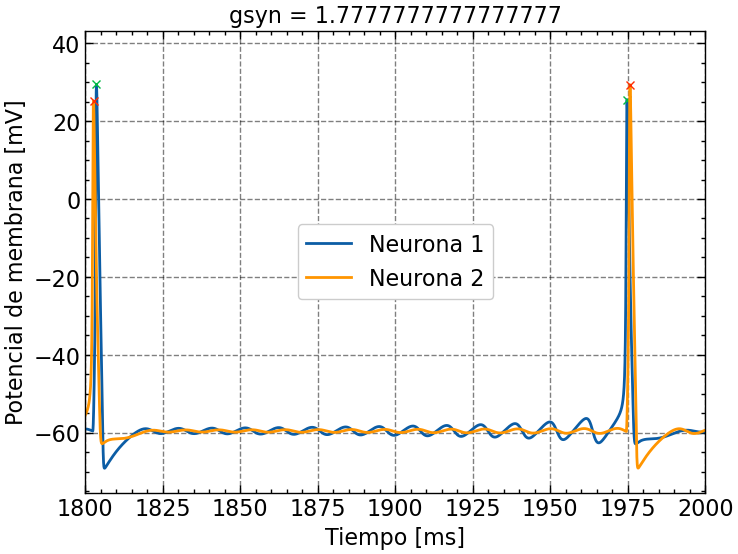

-------------------------------------
gsyn = 2.0
Delta spikes: 227.0400000000002, ms
Desfasaje: -0.9300000000000637, ms -> -0.03 rad
-------------------------------------


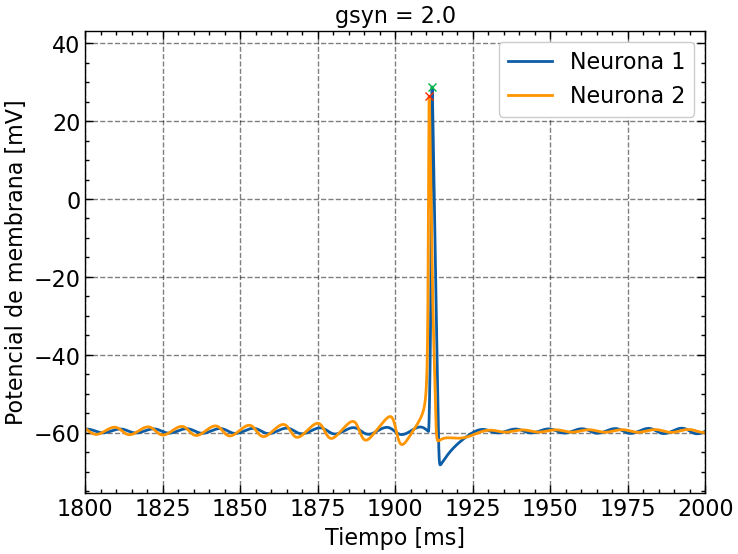

In [18]:
plot = True

time_axis = np.arange(*time_limits, delta_t)
desfasajes = np.empty(N_gsyn_points)

print(results.shape)

x_lims = (1800, 2000)

for i, gsyn in enumerate(gsyn_values):
    peaks = np.empty((N_neurons, ), dtype=object)
    for j in range(N_neurons):
        p, _ = find_peaks(results[i, :, 0, j], height=-20, distance=100)
        if p.size > 0:
            peaks[j] = p
        else:
            peaks[j] = np.nan   # no encontró picos

    # detección de desfasaje
    if np.isnan(peaks[0]).any() or np.isnan(peaks[1]).any():
        desfasajes[i] = np.nan
    else:
        delta_spike = time_axis[peaks[0][-1]] - time_axis[peaks[0][-2]]
        d = time_axis[peaks[1][-1]] - time_axis[peaks[0][-1]]

        if d > delta_spike:
            print('Agarro mal el pico')
            d1 = time_axis[peaks[1][-1]] - time_axis[peaks[1][-2]]
            d2 = time_axis[peaks[0][-2]] - time_axis[peaks[0][-1]]

            d = min(d1, d2)

        desfasajes[i] = 2*np.pi*d/delta_spike

    print('-------------------------------------')
    print(f'gsyn = {gsyn}')
    print(f'Delta spikes: {delta_spike}, ms')
    print(f'Desfasaje: {d}, ms -> {desfasajes[i]:.2f} rad')

    print('-------------------------------------')


    if plot:
        plt.figure()
        plt.plot(time_axis, results[i, :, 0, 0], label='Neurona 1')
        plt.plot(time_axis[peaks[0]], results[i, :, 0, 0][peaks[0]], 'x')
        plt.plot(time_axis, results[i, :, 0, 1], label='Neurona 2')
        plt.plot(time_axis[peaks[1]], results[i, :, 0, 1][peaks[1]], 'x')
        plt.xlim(*x_lims)
        plt.title(f'gsyn = {gsyn}')
        plt.xlabel('Tiempo [ms]')
        plt.ylabel('Potencial de membrana [mV]')
        plt.legend()
        plt.show()
    

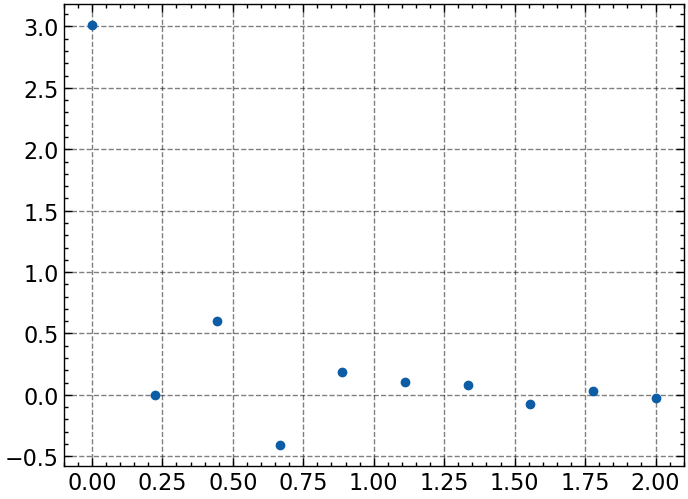

In [19]:
plt.plot(gsyn_values, desfasajes, 'o')